In [1]:
import multiprocessing
import pandas as pd
import numpy as np
import scipy.stats as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import PatchCollection
import dask.dataframe as dd
import os

multiprocessing.cpu_count()

16

## Reading tree data, allometric equations, etc... ##
Read in the data and clean it up

In [2]:
# path to file
home = os.path.expanduser('~')
path = f'{home}/UrbanForest/all_clean_LAcounty_sunset.hdf'

# read the hdf
la = pd.read_hdf(path, key='data')

# select desired columns
cols=['ID', 'LATITUDE', 'LONGITUDE', 'DBH_LO', 'DBH_HI', 'CREATED',
      'UPDATED', 'SOURCE', 'Name_matched', 'Zone']
la = la[cols]

# drop NAs
la.dropna(how='any', axis=0, subset=['DBH_LO', 'DBH_HI'], inplace=True)

# capitalize genus names
la['Name_matched'] = la.Name_matched.str.capitalize()

# convert DBH to cm
la['dbh_low']  = 2.54 * la.DBH_LO
la['dbh_high'] = 2.54 * la.DBH_HI
la.drop(['DBH_LO', 'DBH_HI'], axis=1, inplace=True)

# Change date fields to dateTime type
la['created'] = pd.to_datetime(la.CREATED)
la['updated'] = pd.to_datetime(la.UPDATED)
la.drop(['CREATED', 'UPDATED'], axis=1, inplace=True)


 We will first use allometric equations from :

 McPherson, E. Gregory; van Doorn, Natalie S.; Peper, Paula J. 2016. Urban tree database.
 Fort Collins, CO: Forest Service Research Data Archive. Updated 21 January 2020.
 https://doi.org/10.2737/RDS-2016-0005

 'Apps min' and 'Apps max' give the input range (cm) that the authors feel 
  that the equations are reliable
 'InlEmp' and 'SoCalC' are Climate zones where the eqs are different.
  SoCalC reference city is Santa Monica, InlEmp is Claremont,
  see Table 1, p16 for further Climate zone details.  
  
  After reading the equations and coefficients, we will get rid of trees that only occur a few times, and trees that we o not have equations for.

In [3]:
# The equations
def mcpherson_eqs():
    '''returns dict of equations from table 3 (p24) of McPherson 2020
    functions use np so as to be vectorized'''

    eq_dict = {'lin'        : (lambda a, b, c, d, e, x, mse: a + b * (x)), 
                'quad'      : (lambda a, b, c, d, e, x, mse: a + b * x + c * x**2),
                'cub'      : (lambda a, b, c, d, e, x, mse: a + b * x + c * x**2 + d * x**3),
                'quart'     : (lambda a, b, c, d, e, x, mse:a + b * x + c *x**2 + d * x**3 + e * x**4), 
                'loglogw1' : (lambda a, b, c, d, e, x, mse: np.exp(a + b * np.log(np.log(x + 1) + (mse/2)))),
                'loglogw2' : (lambda a, b, c, d, e, x, mse: np.exp(a + b * np.log(np.log(x + 1)) + (np.sqrt(x) + (mse/2)))),
                'loglogw3' : (lambda a, b, c, d, e, x, mse: np.exp(a + b * np.log(np.log(x + 1)) + (x) + (mse/2))),
                'loglogw4' : (lambda a, b, c, d, e, x, mse: np.exp(a + b * np.log(np.log(x + 1)) + (x**2) + (mse/2))),
                'expow1'    : (lambda a, b, c, d, e, x, mse: np.exp(a+ b * (x) + (mse/2))),
                'expow2'    : (lambda a, b, c, d, e, x, mse: np.exp(a + b * (x) + np.sqrt(x) + (mse/2))),
                'expow3'    : (lambda a, b, c, d, e, x, mse: np.exp(a + b * (x) + (x) + (mse/2))),
                'expow4'    : (lambda a, b, c, d, e, x, mse: np.exp(a + b * (x) + (x**2) + (mse/2)))}

    return(eq_dict)

eq_dict = mcpherson_eqs()

# The cooeficients
coef_df = pd.read_csv('TS6_Growth_coefficients.csvx',
usecols=['Region', 'Scientific Name', 'Independent variable', 'Predicts component ', 'EqName', 'Units of predicted components',
'EqName', 'a', 'b', 'c', 'd', 'e', 'Apps min', 'Apps max'])

# Find all the trees with over 100 occurances in the dataset
trees = la.Name_matched.value_counts()
trees = list(trees.where(trees > 100).dropna().index)

# drop trees we do not have equations for
trees = [s for s in trees if s in coef_df['Scientific Name'].unique()]
la = la.loc[la.Name_matched.isin(trees)]

la.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 664155 entries, 0 to 1089845
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   ID            664155 non-null  int64         
 1   LATITUDE      664155 non-null  float64       
 2   LONGITUDE     664155 non-null  float64       
 3   SOURCE        664155 non-null  object        
 4   Name_matched  664155 non-null  object        
 5   Zone          663384 non-null  float64       
 6   dbh_low       664155 non-null  float64       
 7   dbh_high      664155 non-null  float64       
 8   created       28472 non-null   datetime64[ns]
 9   updated       28472 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(5), int64(1), object(2)
memory usage: 55.7+ MB


## Accessing Lidar data ## 
We will be using the ```USGS_LPC_CA_LosAngeles_2016_LAS_2018``` dataset.  The USGS lidar data is hosted in an Amazon S3 bucket, so we will need the AWS client to access it.

In [4]:
#!curl "https://s3.amazonaws.com/aws-cli/awscli-bundle.zip" -o "awscli-bundle.zip"
#!unzip awscli-bundle.zip 
#!./awscli-bundle/install -b ~/bin/aws

Let's make a tmp directory too, if we don't already have one.

In [5]:
# make a tmp directory

!mkdir ~/tmp

# make a variable for its path
tmp = f'{home}/tmp'

# make a variable with the path to aws cli
aws = '~/bin/aws'

mkdir: cannot create directory ‘/home/jovyan/tmp’: File exists


### Fetching the ept metadata ###
The top level ept json for the ```USGS_LPC_CA_LosAngeles_2016_LAS_2018``` dataset contains important metadata. We will download it.

In [6]:
import subprocess
cmd = f'{aws} s3 cp s3://usgs-lidar-public/USGS_LPC_CA_LosAngeles_2016_LAS_2018/ept.json {tmp} --no-sign-request'
subprocess.run(cmd, shell=True, capture_output=True)

CompletedProcess(args='~/bin/aws s3 cp s3://usgs-lidar-public/USGS_LPC_CA_LosAngeles_2016_LAS_2018/ept.json /home/jovyan/tmp --no-sign-request', returncode=0, stdout=b'Completed 2.4 KiB/2.4 KiB (8.5 KiB/s) with 1 file(s) remaining\rdownload: s3://usgs-lidar-public/USGS_LPC_CA_LosAngeles_2016_LAS_2018/ept.json to ../tmp/ept.json\n', stderr=b'')

We will load ```ept.json``` and extract usefull information.

In [60]:
import json
with open(f'{tmp}/ept.json') as f:
    meta = json.load(f)
    
bounds = meta['bounds']
bounds_conf = meta['boundsConforming']
srs = meta['srs']
span   = meta['span']
schema  = meta['schema']
dataType = meta['dataType']
hierarchyType = meta['hierarchyType']

def bag_scale_offset(name, schema):
    '''Retruns scale and offset for the spatial dimension given by name'''
    for thing in schema:
        if thing['name'] == name:
            return(thing['scale'], thing['offset'])
        
x_scale, x_offset = bag_scale_offset('X', schema)
y_scale, y_offset = bag_scale_offset('Y', schema)
z_scale, z_offset = bag_scale_offset('Z', schema)

#print some info
print(f'dataType is: {dataType}\nhierarchyType is: {hierarchyType}\nsrs is:\n{srs}')

dataType is: laszip
hierarchyType is: json
srs is:
{'authority': 'EPSG', 'horizontal': '3857', 'wkt': 'PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["X",EAST],AXIS["Y",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext +no_defs"],AUTHORITY["EPSG","3857"]]'}


The above output tells us the data is in EPSG:3857.  There is only a horizontal code present.  Lets reduce the srs to a more useful form for later

In [61]:
srs = meta['srs']['authority'] + ':' + meta['srs']['horizontal']
srs

'EPSG:3857'

Because the srs is in Pseudo-Mercator (EPSG:3857), and our data is lat, lon (EPSG:4326) We will have to reproject. 

### Querying data ###
Now it should be possible to define a bounding box around a tree to query the ept.

In [62]:
from osgeo import osr

# For now we will ad 0.00007 degrees in each direction, this is jus a guess based on 5th decimal place ~ 1.1m
# also not setting z max and min for the moment
def make_scaled_bbox(lat, lon, bounds=None):
    '''Returns a bbox in ept coords.
    If present bounds is of form [xmin, ymin, zmin, xmax, ymax, zmax]'''
    # make the bbox in EPSG:4326
    [xmin, xmax], [ymin, ymax] = make_bbox(lat, lon)
    
    # define transform from EPSG:4326 to EPSG:3857
    old_crs = osr.SpatialReference() 
    old_crs.ImportFromEPSG(4326) 
    new_crs = osr.SpatialReference() 
    new_crs.ImportFromEPSG(3857)
    transform = osr.CoordinateTransformation(old_crs,new_crs)
    
    # transform bbox points
    xmin, ymin, zmin = transform.TransformPoint(ymin, xmin)
    xmax, ymax, zmax = transform.TransformPoint(ymax, xmax)

    # TODO:make sure no bbox is out of the ept bbox, for edge cases
    # if bounds:
        #blah for blah in blah
    
    return([xmin, xmax], [ymin, ymax])

def make_bbox(lat, lon):
    buf = 0.00007
    xmin = lon - buf
    ymin = lat - buf
    xmax = lon + buf
    ymax = lat + buf
    return([xmin, xmax], [ymin, ymax])

def bbox_geojson(lat, lon, filename):
    '''makes wgs84 bbox as geojson for comparison in gis'''
    [xmin, xmax], [ymin, ymax] = make_bbox(lat, lon)
    gjson = {'coordinates' : [[[xmin, ymin], [xmin, ymax], [xmax, ymax], [xmax, ymin]]],
            'type' : 'Polygon'}
    with open(filename, 'w') as of:
        json.dump(gjson, of)

In [12]:
#pip install pdal

Now lets try to get the point cloud within the bbox using PDALs ept reader

In [13]:
import pdal
from string import Template

To test things out we will select a single tree.  ```id``` is the uniqued ID for the tree in the dataset

In [152]:
# get the lat, lon of point from dataset
uid = 2181656
lat = la.loc[la.ID==uid]['LATITUDE'].values[0]
lon = la.loc[la.ID==uid]['LONGITUDE'].values[0]
species = la.loc[la.ID==uid]['Name_matched'].values[0]

# get bbox coords in EPSG:4326
[xmin, xmax], [ymin, ymax] = make_bbox(lat, lon)

# make geojson of bbox in EPSG:4326
bbox_geojson(lat, lon, f'bbox_{id}.json')

# make transformed bbox
scaled_bbox = make_scaled_bbox(lat, lon, bounds=bounds)

In [159]:
species
# UTM11 is EPSG:26911

'Ulmus parvifolia'

In [154]:
# make and validate pipeline
t = Template('''
{
    "pipeline": [
        {
        "bounds": "${scaled_bbox}",
        "filename": "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/USGS_LPC_CA_LosAngeles_2016_LAS_2018/ept.json",
        "type": "readers.ept",
        "tag": "readdata",
        "spatialreference":"${srs}"
        },
        {
        "type":"filters.outlier",
        "method":"radius",
        "radius":1.0,
        "min_k":4
        },
        {
        "type": "filters.reprojection",
        "in_srs":"${srs}",
        "out_srs": "EPSG:26911"
        },
        {
        "filename": "dsm${uid}.tif",
        "gdalopts": "tiled=yes,     compress=deflate",
        "nodata": -9999,
        "output_type": "idw",
        "resolution": 1,
        "type": "writers.gdal",
        "window_size": 6
        },
        {
        "type":"filters.smrf",
        "scalar":1.2,
        "slope":0.2,
        "threshold":0.45,
        "window":16.0
        },
        {
        "type":"filters.hag_delaunay"
        },
        {
        "filename": "chm${uid}.tif",
        "gdalopts": "tiled=yes,     compress=deflate",
        "nodata": -9999,
        "output_type": "idw",
        "resolution": 1,
        "type": "writers.gdal",
        "window_size": 6,
        "dimension": "HeightAboveGround"
        }
    ]
}''')

pipe = t.substitute(scaled_bbox=scaled_bbox, srs=srs, bbox=bbox, uid=uid)

In [155]:
pipeline = pdal.Pipeline(pipe)

In [156]:
pipeline.validate()

True

In [157]:
count = pipeline.execute()

In [158]:
count

1694

In [188]:
S = pipeline.arrays[0]
metadata = pipeline.metadata
log = pipeline.log
S[:4]

array([(8, 1, 0, 1.35500602e+08, 448, 1, 4397, 599, 1, 6., 0, 0, 0, 371172.4740487 , 3770101.19563006, 73.39, 11.74536149),
       (0, 2, 0, 1.39906530e+08, 672, 1, 4397, 401, 1, 0., 0, 1, 0, 371172.75382964, 3770101.64577229, 61.57,  0.        ),
       (8, 7, 0, 1.35500602e+08, 704, 2, 4397, 599, 1, 6., 0, 1, 0, 371172.37368599, 3770109.02989164, 68.52,  6.77512558),
       (8, 7, 0, 1.35500602e+08, 944, 3, 4397, 599, 1, 6., 0, 1, 0, 371174.46243239, 3770108.96836512, 70.95,  9.33109817)],
      dtype=[('ClassFlags', 'u1'), ('Classification', 'u1'), ('EdgeOfFlightLine', 'u1'), ('GpsTime', '<f8'), ('Intensity', '<u2'), ('NumberOfReturns', 'u1'), ('OriginId', '<u4'), ('PointSourceId', '<u2'), ('ReturnNumber', 'u1'), ('ScanAngleRank', '<f4'), ('ScanChannel', 'u1'), ('ScanDirectionFlag', 'u1'), ('UserData', 'u1'), ('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('HeightAboveGround', '<f8')])

So, the pipline made a DSM for the query box.  We also now have the returns in an np structured array, ```S```.

In [189]:

veg = S[S['Classification']!=2]

h = veg['HeightAboveGround'].flatten()

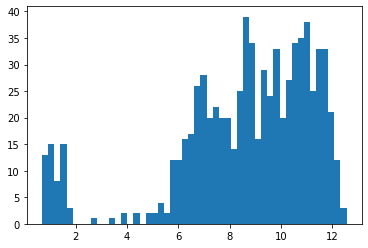

In [190]:
import matplotlib.pyplot as plt

plt.hist(h, bins=50);

Here is where we do stuff with the data...  Figure this out, then use the section below to do it en masse.

In [86]:
from scipy import ndimage as ndi

#Import biomass specific libraries
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from sklearn.ensemble import RandomForestRegressor


### Making a loop of it and parrallelizing it etc...  ###

In [77]:
#from tqdm import tqdm
from dask import delayed
from dask import compute
from dask.diagnostics import ProgressBar



@delayed
def row_bounds_ept_query(i):
    # get lat lon of first entry
    row = la.iloc[i]
    ident = row['ID']
    lat = row['LATITUDE']
    lon = row['LONGITUDE']

    # make bbox in the ept coord system
    scaled_bbox = make_scaled_bbox(lat, lon, bounds=bounds_conf)
    
    # sanity check will raise erros if scalled bbox is not in the ept bounds
    assert (scaled_bbox[0][0] > bounds[0]) & (scaled_bbox[0][1] < bounds[3])
    assert (scaled_bbox[1][0] > bounds[1]) & (scaled_bbox[1][1] < bounds[4])
    
    # make and validate pipeline
    t = Template('''
    {
        "pipeline": [
            {
            "bounds": "${scaled_bbox}",
            "filename": "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/USGS_LPC_CA_LosAngeles_2016_LAS_2018/ept.json",
            "type": "readers.ept",
            "tag": "readdata",
            "spatialreference":"${srs}"
            },
            {
            "type": "filters.reprojection",
            "in_srs":"${srs}",
            "out_srs": "EPSG:26911"
            },
            {
            "filename": "xxx.laz",
            "type": "writers.las"
            },
            {
            "filename": "dsm${id}.tif",
            "gdalopts": "tiled=yes,     compress=deflate",
            "nodata": -9999,
            "output_type": "idw",
            "resolution": 1,
            "type": "writers.gdal",
            "window_size": 6
            }
        ]
    }''')

    pipe = t.substitute(scaled_bbox=scaled_bbox, srs=srs, bbox=bbox, id=ident)
    pipeline = pdal.Pipeline(pipe)
    pipeline.validate()
    
    # execuite pipeline
    count = pipeline.execute()
    S = pipeline.arrays[0]
    metadata = pipeline.metadata
    log = pipeline.log
    
    # do stuff
    sh = S.shape
    if sh[0] > 0:
        print(f'{ident} is a numpy structured array of shape {sh}.')
        return(S)
        
results = []
for i in range(1):
    results.append(row_bounds_ept_query(i+10))
    
with ProgressBar():
    S = compute(*results)

[                                        ] | 0% Completed |  0.0s712181 is a numpy structured array of shape (1751,).
[########################################] | 100% Completed |  3.1s
